<a href="https://colab.research.google.com/github/mhmetglrq/socialNetworkGNN/blob/master/socialNetworkGNN_ipynb_adl%C4%B1_not_defterinin_kopyas%C4%B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# PyTorch ve PyTorch Geometric kur
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!pip install torch-geometric


Looking in indexes: https://download.pytorch.org/whl/cpu


In [ ]:
import pandas as pd
import torch
from torch_geometric.data import Data

# Veri dosyasını yükle
file_path = "/content/soc-twitter-higgs.edges"
edges = pd.read_csv(file_path, sep=" ", header=None, names=["src", "dst"])

# Düğümleri yeniden sıralamak için indeksleme
node_mapping = {node: idx for idx, node in enumerate(pd.concat([edges["src"], edges["dst"]]).unique())}
edges["src"] = edges["src"].map(node_mapping)
edges["dst"] = edges["dst"].map(node_mapping)

# Kenar listesini PyTorch Geometric formatına çevir
edge_index = torch.tensor(edges.values.T, dtype=torch.long)

# Düğüm özelliklerini rastgele oluştur (örnek için)
num_nodes = len(node_mapping)
node_features = torch.rand(num_nodes, 16)  # Her düğüm için 16 özellik

# Etiketleri rastgele oluştur (örnek için 3 topluluk)
labels = torch.randint(0, 3, (num_nodes,))

# PyTorch Geometric veri nesnesi
data = Data(x=node_features, edge_index=edge_index, y=labels)


In [ ]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


In [ ]:
# Model, optimizer ve kayıp fonksiyonu
model = GCN(input_dim=16, hidden_dim=32, output_dim=3)  # 3 topluluk etiketi varsayımı
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

# Eğitim döngüsü
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out, data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

# Modeli eğit
for epoch in range(10):  # 200 epoch
    loss = train()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")


Epoch 0, Loss: 1.3196


In [ ]:
# Modeli değerlendirme
model.eval()
pred = model(data).argmax(dim=1)  # Tahmin edilen topluluk etiketleri

# İlk birkaç düğümün gerçek ve tahmin edilen etiketlerini göster
print("Gerçek Etiketler:", data.y[:10].tolist())
print("Tahmin Edilen Etiketler:", pred[:10].tolist())


Gerçek Etiketler: [2, 2, 1, 0, 1, 2, 2, 2, 2, 1]
Tahmin Edilen Etiketler: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


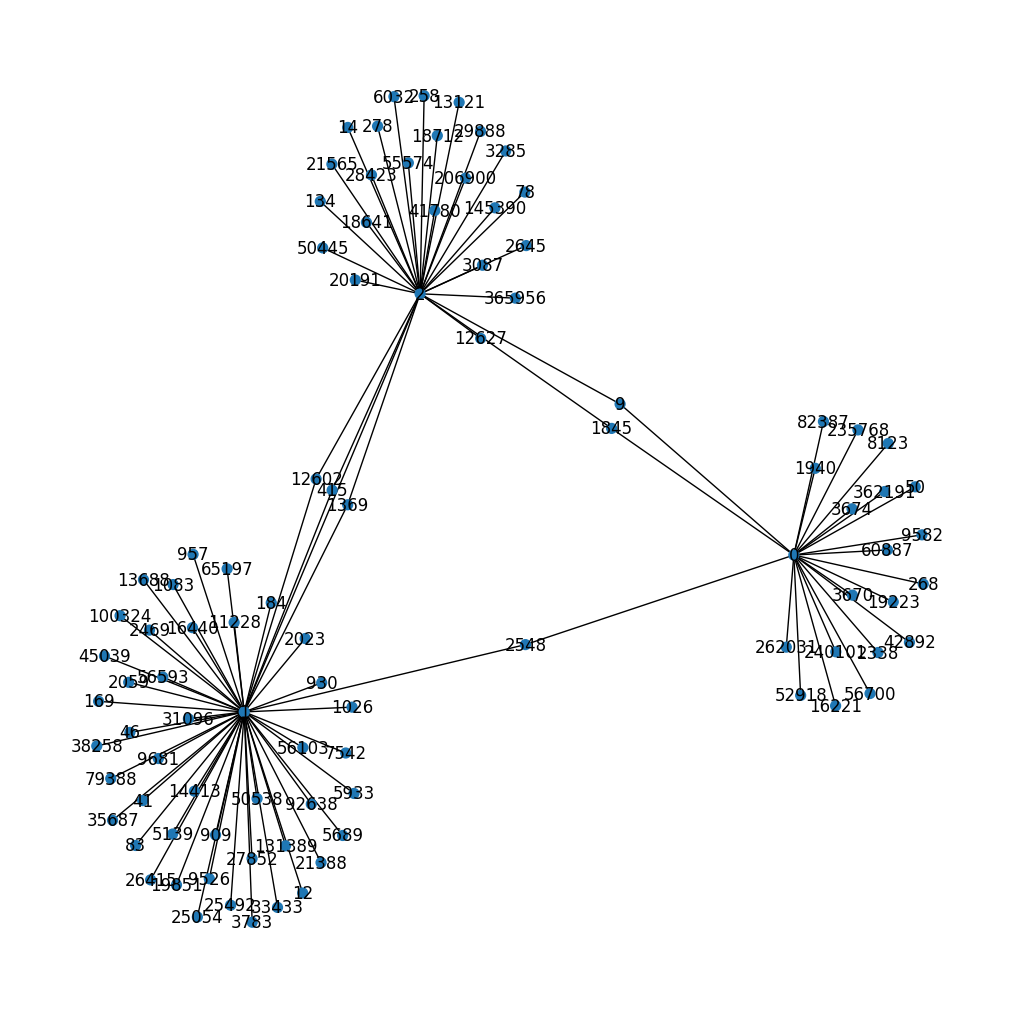

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# NetworkX grafiği oluştur
subset_edges = edges.head(100)  # İlk 100 kenarı al
G = nx.from_pandas_edgelist(subset_edges, source="src", target="dst")
colors = [pred[node].item() for node in G.nodes()]

# Grafiği çizdir
plt.figure(figsize=(10, 10))
nx.draw(G, node_color=colors, with_labels=True, cmap=plt.cm.tab10, node_size=50)
plt.show()
